In [152]:
import pandas as pd
import numpy as np

import sys
sys.path.append('../')

import os

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [153]:
date = '2025-01-19'
data = pd.read_csv('../data/oresund/'+date+'.csv') #Import data
data = data.drop_duplicates() #Drop duplicates (there are many!)

Making a copy to manipulate

In [154]:
data_filter = data.copy()

Filtering out helicopters which are faster than 60 knots (or else it's a spurious incident)

In [155]:
#I filter for helicopter
data_filter = data_filter[(data_filter['SOG'] < 60) | (data_filter['SOG'].isna())]

Resampling the series so there's a minimum five minute interval between measurements
This period is of coursse arbitrary, but seems to be a good compromise between memory and resolution
A ship moves $5/60 \cdot 20 \approx 1.6 km$ when sailing fast

In [156]:
data_temp = pd.DataFrame(columns=data_filter.columns)

for MMSI in data_filter['MMSI'].unique():
    ship = data_filter[data_filter['MMSI'] == MMSI]
    #Creating a series for time filtering
    series = pd.Series(range(len(ship)), index=pd.to_datetime(ship['# Timestamp'], dayfirst=True))
    #Resampling the series to 5 minutes. This gives the index of the last data point in the 5 minute interval
    #The unique is added because if transmission occurs less frequently than 5 mins there will be duplicates
    resampled = series.resample('5min').first().dropna().astype(int)
    #Filtering the data
    ship = ship.iloc[resampled]
    data_temp = pd.concat([data_temp, ship], ignore_index=True)

data_filter = data_temp.copy()

/var/folders/29/jqsnm5js6_sc7663vjsq3mp40000gp/T/ipykernel_9712/3287667159.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_temp = pd.concat([data_temp, ship], ignore_index=True)


Now we filter out buoys and aids to navigation ('base station' and 'AtoN')

In [157]:
print(data['Type of mobile'].unique())
data_filter = data_filter[(data_filter['Type of mobile']!='Base Station') & (data_filter['Type of mobile']!='AtoN')]
print(data_filter['Type of mobile'].unique())

['Class A' 'Class B' 'Base Station' 'AtoN']
['Class A' 'Class B']


Appending the dataset with distance measure which is signed depending on whether ship is north or south of Oresund (see Trials/Oresund_distance_calc)

In [158]:
#Defining parameters for oresund bridge
long_or = (12.682873, 12.88866)
lat_or = (55.628996, 55.564952)

#Using a flat earth approximation to calculate the slope (in lat/lon) of the bridge
slope_or = (lat_or[1]-lat_or[0])/(long_or[1] - long_or[0])

#Defining function for the corridor going perpendicular to the bridge
def corridor_lon(lat):
    west = -slope_or*(lat - lat_or[0]) + long_or[0]
    east = -slope_or*(lat - lat_or[1]) + long_or[1]
    return west, east

#Calculating the corridor on the latitudes that all the ships are in
west, east = corridor_lon(data_filter['Latitude'])
in_corridor = data_filter['Longitude'].between(west, east) #If the ship is in the corridor
west_of_corridor = data_filter['Longitude'] < west #If the ship is west of the corridor
east_of_corridor = data_filter['Longitude'] > east #If the ship is east of the corridor

#Calculating the distance
lat_dist = 6378*2*np.pi/360 #Latituda distance in km using radius of earth
lon_dist = lat_dist * np.cos(lat_or[0]*np.pi/180) #Longitude distance in km using radius of earth and latitude of bridge

#"distance" coordinates of each ship (will convert to real distances when subtracted from the bridge)
x = data_filter['Longitude']*lon_dist
y = data_filter['Latitude']*lat_dist

x_or = np.array(long_or)*lon_dist
y_or = np.array(lat_or)*lat_dist

bridge_vec_deg = np.array([1, slope_or]) #Bridge vector in degrees
bridge_vec_dist = bridge_vec_deg * np.array([lon_dist, lat_dist]) #Bridge vector in km
n = np.array([-bridge_vec_dist[1], bridge_vec_dist[0]]) #Normal vector to the bridge vector in km
n = n/np.linalg.norm(n) #Normalized normal vector
perp_dist = (x-x_or[0])*n[0] + (y-y_or[0])*n[1] #Perpendicular distance using projection onto normal vector
above = (perp_dist > 0)*2 - 1 #If the ship is above or below the bridge
dist_west = above*np.sqrt((x-x_or[0])**2 + (y-y_or[0])**2) #Signed distance to the west bridge point
dist_east = above*np.sqrt((x-x_or[1])**2 + (y-y_or[1])**2) #Signed distance to the east bridge point

#If the ship is in corridor use the perpendicular distance, else use the closest distance to the bridge
data_filter['Distance'] = perp_dist * in_corridor + dist_west * west_of_corridor + dist_east * east_of_corridor

In [159]:
data_filter.columns

Index(['# Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude',
       'Navigational status', 'SOG', 'COG', 'Heading', 'Ship type',
       'Cargo type', 'Width', 'Length', 'Destination', 'Distance'],
      dtype='object')

Now we create the real dataset \
Every datapoint is a triple with (distance, speed, time to cross)

Loop over all ships and
1) Decide if ship is crossing
2) Find time of crossing
3) Calculate time until crossing
4) Calculate speed
5) Append all relevant datapoints

In [160]:
final = pd.DataFrame(columns=['MMSI', 'Time', 'Distance', 'SOA', 'TTC'])

for MMSI in data_filter['MMSI'].unique():
    ship = data_filter[data_filter['MMSI'] == MMSI]
    dist = ship['Distance'].values
    time = pd.to_datetime(ship['# Timestamp'], dayfirst=True)
    time = (time - time.iloc[0]).dt.total_seconds().values / (60*60) #Time in hours
    soa = (dist[1:] - dist[:-1]) / (time[1:] - time[:-1])
    #Rewriting time and dist so it has same dimensions as soa (for ease of indexing later)
    time, dist = time[1:], dist[1:]

    cross_line = ((dist[:-1]*dist[1:]) < 0) #if the ship crosses the bridge the distances have different signs
    crossings = np.where(cross_line)[0] #Indices of crossings. ship.iloc[crossing] is just BEFORE the crossing
    prev_cross = 0
    for crossing in crossings: #Iterating over the crossings. This code only runs if there is a crossing
        if ship['Longitude'].values[crossing] > 12.665767: #If the ship is not in Copenhagen habour (specific rule for this data set)
            #A weighted average to estimate the crossing time
            cross_time = (np.abs(dist[crossing+1])*time[crossing] + np.abs(dist[crossing])*time[crossing + 1])/(np.abs(dist[crossing+1]) + np.abs(dist[crossing]))
            soa_temp = soa[prev_cross:crossing+1]
            time_temp = time[prev_cross:crossing+1]
            dist_temp = dist[prev_cross:crossing+1]
            #I am only interested in phases of sailing towards the bridge
            indexing = soa_temp*dist_temp < 0
            temp = pd.DataFrame({'MMSI': np.full(np.sum(indexing), MMSI), 'Time': time_temp[indexing], 'Distance': dist_temp[indexing], 'SOA': soa_temp[indexing], 'TTC': cross_time - time_temp[indexing]})
            final = pd.concat([final, temp], ignore_index=True)
            prev_cross = crossing


/var/folders/29/jqsnm5js6_sc7663vjsq3mp40000gp/T/ipykernel_9712/871613587.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final = pd.concat([final, temp], ignore_index=True)


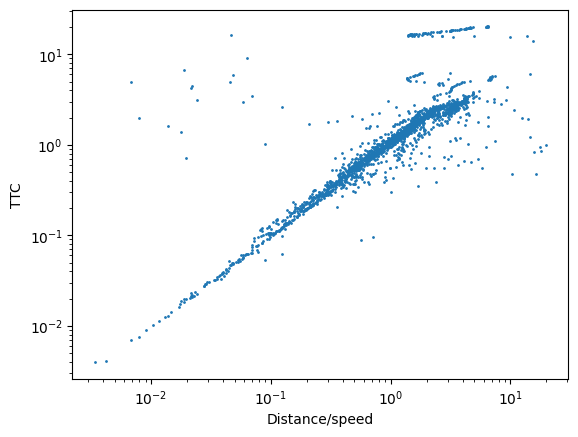

In [161]:
threshold = 20
x = np.abs(final['Distance']/final['SOA'])
y = final['TTC']
indexing = x<threshold
plt.scatter(x[indexing], y[indexing], s=1)
plt.ylabel('TTC')
plt.xlabel('Distance/speed')
plt.xscale('log')
plt.yscale('log')

[ -32.05659037   -1.72026305 -215.48635775   63.44043871]
[257186000 219001819 266262000]


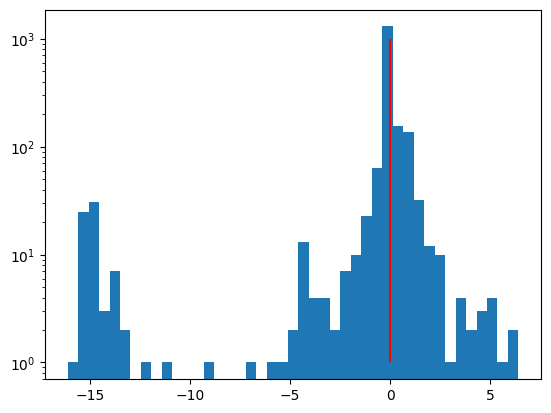

In [186]:
estimator = np.abs(final['Distance']/final['SOA'])
true = final['TTC']
indexing = estimator < 10
error = (estimator[indexing] - true[indexing])

plt.hist(error, bins=int(np.sqrt(len(error))))
plt.yscale('log')
plt.vlines(0, 1, 1000, colors='red')
print(np.array([error.mean(), error.median(), error.quantile(0.05), error.quantile(0.95)])*60)

temp = final[indexing]
print((temp[error < -10]['MMSI']).unique())

In [163]:
temp[error < -10][['MMSI', 'Time']]

,MMSI,Time
0,257186000,0.083056
1,257186000,0.166389
2,257186000,0.249722
3,257186000,0.333333
4,257186000,0.416667
...,...,...
163,219001819,1.083056
164,219001819,1.166667
165,219001819,1.249444
1253,266262000,1.064444


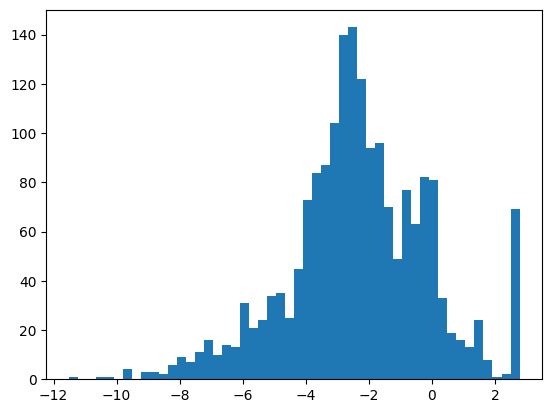

In [164]:
#log visualisation
logerror = np.log(np.abs(error))
plt.hist(logerror, bins=50);

0.03508203819415915 -0.049556993772644456 -0.684749553732381 0.5221723937696878


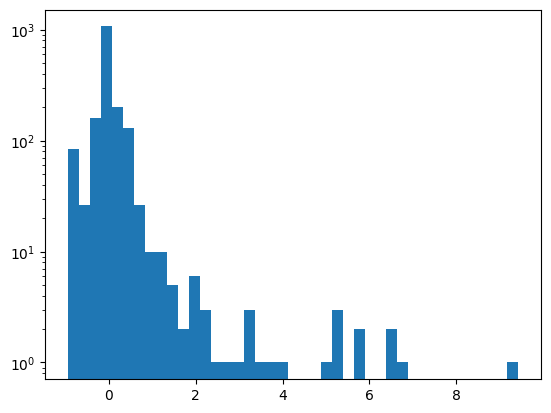

In [198]:
#Lookign at relative error
estimator = np.abs(final['Distance']/final['SOA'])
true = final['TTC']

indexing = (estimator < 10) & (estimator > 0.1)
rel = ((estimator - true)/true)[indexing]

plt.hist(rel, bins=int(np.sqrt(len(rel))))
plt.yscale('log')

print(rel.mean(), rel.median(), rel.quantile(0.05), rel.quantile(0.95))

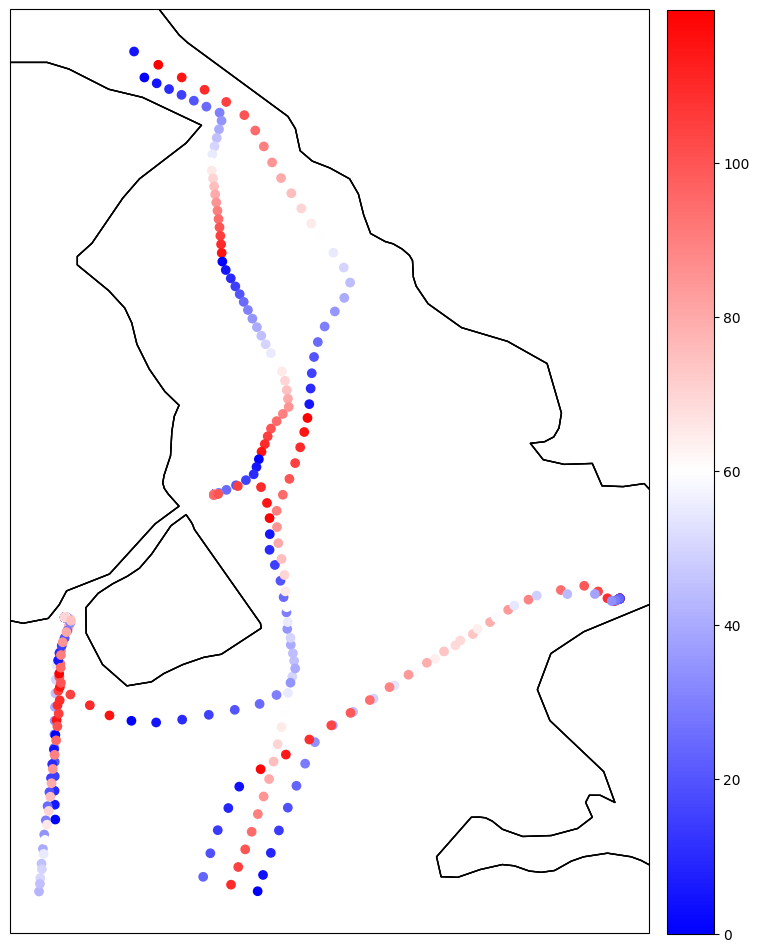

In [165]:
interests = [257186000, 219001819, 266262000]

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 12))

for i in range(len(interests)):
    ship = data_filter[data_filter['MMSI']==interests[i]]
    time = pd.to_datetime(ship['# Timestamp'], dayfirst=True)
    time = (time - time.iloc[0]).dt.total_seconds() / (60)
    ax.scatter(ship['Longitude'], ship['Latitude'], transform=ccrs.PlateCarree(), c=time%120, cmap='bwr')
    ax.add_feature(cfeature.COASTLINE)

cbar = plt.colorbar(ax.collections[0], ax=ax, orientation='vertical', pad=0.02)

#The only weird thing is the one in malmø!!!
#Have to look closer at that one
#The two others sail weirdly and goes into habour suddenly!

0.0364892770087592


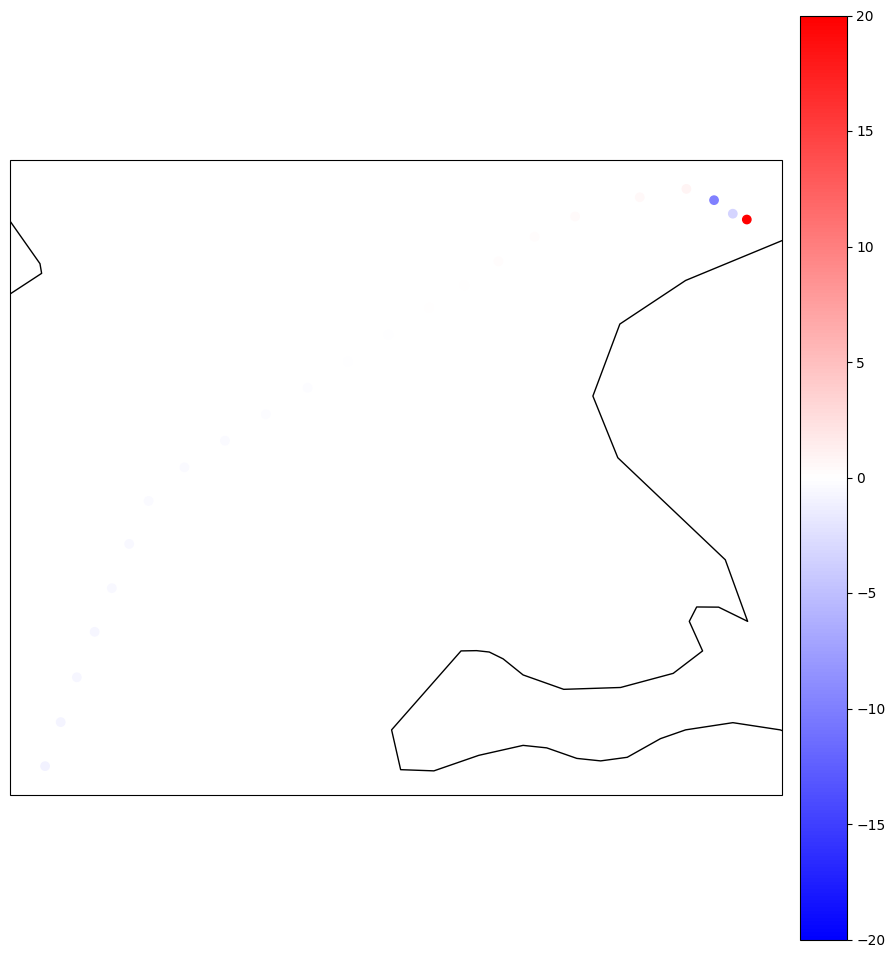

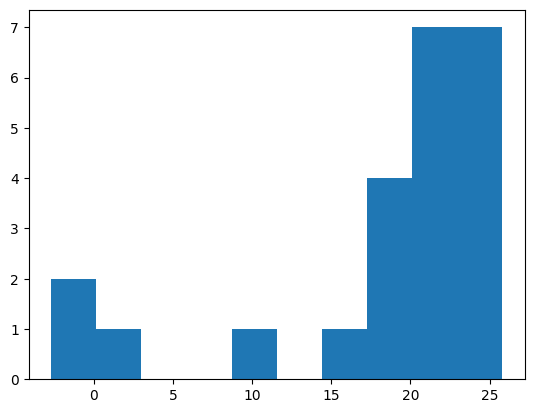

In [ ]:
interest = 266262000
ship = data_filter[data_filter['MMSI']==interest]
time = pd.to_datetime(ship['# Timestamp'], dayfirst=True)
time = ((time - time.iloc[0]).dt.total_seconds() / (60*60)).values

indexing = time<1.9
ship, time = ship[indexing], time[indexing]

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 12))

dist = ship['Distance'].values
soa = (dist[1:] - dist[:-1]) / (time[1:] - time[:-1])
ship = ship.iloc[1:]

ax.scatter(ship['Longitude'], ship['Latitude'], transform=ccrs.PlateCarree(), c=dist[1:]/soa, cmap='bwr', vmin=-20, vmax=20)
ax.add_feature(cfeature.COASTLINE)



colorbar = plt.colorbar(ax.collections[0], ax=ax, orientation='vertical', pad=0.02)



plt.figure()
plt.hist(soa)
print(np.min(np.abs(dist[1:]/soa)))

#Found the two places!
#As it moves into the harbour it turns slightly towards Øresundsbroen!!!


In [201]:
#Some investigation of what ships cross Oresund
print(data_filter.columns)

print(len(final['MMSI'].unique())/len(data_filter['MMSI'].unique()))

def find_unique(colname):
    res = []
    for MMSI in final['MMSI'].unique():
        res = res + list(data_filter[data_filter['MMSI']==MMSI][colname].unique())
    return np.unique(res)

for colname in ['Type of mobile', 'Navigational status', 'Ship type',
       'Cargo type', 'Destination']:
    print(colname)
    print(data_filter[colname].unique(), find_unique(colname))

Index(['# Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude',
       'Navigational status', 'SOG', 'COG', 'Heading', 'Ship type',
       'Cargo type', 'Width', 'Length', 'Destination', 'Distance'],
      dtype='object')
0.17473118279569894
Type of mobile
['Class A' 'Class B'] ['Class A' 'Class B']
Navigational status
['Under way using engine' 'Unknown value' 'Moored'
 'Restricted maneuverability' 'At anchor'
 'Power-driven vessel pushing ahead or towing alongside'
 'Not under command'] ['Moored' 'Restricted maneuverability' 'Under way using engine'
 'Unknown value']
Ship type
['Undefined' 'Passenger' 'Pilot' 'Pleasure' 'Cargo' 'SAR' 'Dredging'
 'Tanker' 'Tug' 'Other' 'Reserved' 'Towing' 'Fishing' 'Sailing'
 'Port tender' 'Law enforcement' 'Military' 'Diving' 'HSC'] ['Cargo' 'Dredging' 'Fishing' 'Military' 'Other' 'Passenger' 'Pilot'
 'Pleasure' 'Tanker' 'Tug' 'Undefined']
Cargo type
[nan 'No additional information' 'Category Y' 'Category X'
 'Reserved for future use' 'Catego

Down here are demonstrations of the workings of the code

In [167]:
ship = data[data['MMSI'] == data['MMSI'].values[49]]
series = pd.Series(range(len(ship)), index=pd.to_datetime(ship['# Timestamp'], dayfirst=True))
resampled = series.resample('5min')
ind_1 = resampled.first().dropna().astype(int)
ind_2 = (resampled.count().cumsum()-1).unique()
print(ind_1.values[:15])
print(ship.iloc[ind_1]['# Timestamp'][:15])
print(ship.iloc[ind_2]['# Timestamp'][:15])
print(ship['# Timestamp'][:15])

[ 0  3  7  9 11 12 13 16 19 21 24 27 28 32 35]
124      19/01/2025 00:00:08
6251     19/01/2025 00:06:09
13371    19/01/2025 00:12:57
15785    19/01/2025 00:15:08
25406    19/01/2025 00:24:08
28485    19/01/2025 00:27:10
31475    19/01/2025 00:30:08
37779    19/01/2025 00:36:08
43849    19/01/2025 00:42:10
50235    19/01/2025 00:48:08
53439    19/01/2025 00:51:09
60392    19/01/2025 00:57:10
63752    19/01/2025 01:00:09
70313    19/01/2025 01:06:09
77721    19/01/2025 01:12:57
Name: # Timestamp, dtype: object
874      19/01/2025 00:00:57
9518     19/01/2025 00:09:09
13404    19/01/2025 00:12:59
19997    19/01/2025 00:18:58
25406    19/01/2025 00:24:08
28485    19/01/2025 00:27:10
34724    19/01/2025 00:33:08
40840    19/01/2025 00:39:09
44724    19/01/2025 00:42:58
51100    19/01/2025 00:48:58
57699    19/01/2025 00:54:57
60392    19/01/2025 00:57:10
67066    19/01/2025 01:03:10
73630    19/01/2025 01:09:09
77721    19/01/2025 01:12:57
Name: # Timestamp, dtype: object
124      19/01/20